# Collateral Shortfall Forecast

This notebook is derived from a previous one available on our website around [Collateral optimization](https://github.com/atoti/notebooks/blob/master/notebooks/collateral-shortfall-monitoring/main.ipynb). For context, we’re copying here the first part of this notebook by [Hui Fang Yeo](https://www.linkedin.com/in/huifang-yeo/). The scenario starts diverging at the ‘What-If’ stage to integrate predictive machine learning algorithms. Jump to that part if you are already familiar with the use case.

For more context and definitions around collateral shortfall monitoring, [check out our article on atoti.io](https://www.atoti.io/rapid-collateral-modelling-and-simulation-with-atoti/).

## Introduction

In this notebook, we will showcase how quickly a dashboard can be put together for a simplified use case of Collateral Shortfall monitoring with atoti libraries.  
  
Collateral is a form of credit risk mitigation where an asset is accepted as security for extending a loan.  
Market value of a collateral changes over time and the lender has to accomodate for it. As such, depending on the amount of risk associated, a percentage of what is known as haircut is applied to the asset's market value. This gives the value of the collateral that can be used for a loan, also known as collateral value.   
  
Collateral Shortfall occurs when the collateral value goes below the cash out value. That meant that the value of collateral is less than what it is expected to be, due to a variety of factors such as market fluctuations, contracts enforceability etc. 

We will be creating a multi-dimensional data cube and derive the various measures such as market value, collateral value after haircut, cash out value over account and thereafter, the Collateral shortfall for the accounts. 

Leveraging on the data cube and atoti's data visualization, we will put together dashboards that reflects collateral status of accounts. As a cherry on top, we will perform some *What if Analysis* based on price simulation to demonstrate the impact on Collateral in the below scenarios:  

- Asset price forecast at 1-day horizon
- Asset price forecast at 3-days horizon
- Asset price forecast at 1-week horizon

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=collateral-monitoring" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover.png" alt="Try atoti"></a></div>

## Getting Started

### Additional Dependencies

As data used in this notebook is stored on AWS S3, it is necessary to install the [atoti-aws plugin](https://docs.atoti.io/latest/plugins.html#available-plugins).

```
!pip install atoti-aws
or 
!conda install atoti-aws
```

### Library Imports

In [1]:
import os

import atoti as tt
import numpy as np
import pandas as pd
import utils
from natsort import natsorted
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from tabulate import tabulate
import boto3

Welcome to atoti 0.6.6!

By using this community edition, you agree with the license available at https://docs.atoti.io/latest/eula.html.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

atoti collects telemetry data, which is used to help understand how to improve the product.
If you don't wish to send usage data, set the ATOTI_DISABLE_TELEMETRY environment variable to True.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


In [2]:
# a session has to be created for atoti
# dashboards are persisted in the content storage
session = tt.Session(user_content_storage="./content")

### Data Loads
A session is used to read data of formats csv, parquet, pandas dataframe, numpy and spark.   
Refer to [this link](https://docs.atoti.io/latest/lib/atoti/atoti.session.html#atoti.Session).
   
#### Loading CSVs

In [3]:
asset_positions_table = session.read_csv(
    "s3://data.atoti.io/notebooks/collateral-shortfall-monitoring/assets_positions.csv",
    keys=["Account", "Asset_Code"],
    table_name="asset_positions",
)
asset_positions_table.head()

Quantity
Account           Asset_Code          
Niel              CAP.PA      100000.0
                  SAN.PA      100000.0
Musk              ENI.PA      100000.0
                  ENGI.PA     100000.0
Bezos & MacKenzie AC.PA       100000.0

#### Loading Parquet

In [4]:
assets_table = session.read_parquet(
    "s3://data.atoti.io/notebooks/collateral-shortfall-monitoring/assets_attributes.parquet",
    keys=["Asset_Code"],
    table_name="assets",
)
assets_table.head()

,Sector,Country,Haircut
Asset_Code,,,
BNP.PA,Financial Services,France,0.1
CA.PA,Consumer Defensive,France,0.1
AC.PA,Consumer Cyclical,France,0.1
ENGI.PA,Utilities,France,0.1
CAP.PA,Technology,France,0.1


#### Loading CSV via Pandas 
Being able to load pandas dataframe gives us the flexibility to manipulate dataframe before loading them or later on when we do simulations.

In [5]:
assets_prices_df = pd.read_csv(
    "s3://data.atoti.io/notebooks/collateral-shortfall-forecast/data/assets-prices-test.csv"
)
assets_prices_df.head()

,Date,AC.PA,BNP.PA,CAP.PA,ENGI.PA,G.MI,RACE.MI,SAN.PA,TIT.MI
0,2021-04-09,33.040001,51.459999,151.000000,12.326,16.965000,174.000000,85.059998,0.433900
1,2021-04-10,32.890001,51.446665,151.216665,12.368,17.000000,174.700002,84.936666,0.435233
2,2021-04-11,32.740000,51.433332,151.433329,12.410,17.035000,175.400004,84.813334,0.436567
3,2021-04-12,32.590000,51.419998,151.649994,12.452,17.070000,176.100006,84.690002,0.437900
4,2021-04-13,32.840000,51.639999,153.500000,12.260,17.084999,176.350006,84.070000,0.435800


Let's transform the dataframe in order to obtain the desired shape: we want to have all the asset names in one column, and all their prices in anotehr column.

To achieve that, we use the ***melt()*** method of the Pandas Dataframe class, available in the Pandas library.

In [6]:
assets_prices_df = assets_prices_df.melt(
    id_vars="Date", var_name="Asset_Code", value_name="Price"
).set_index(["Asset_Code", "Date"])
assets_prices_df.head()

Price
Asset_Code Date                 
AC.PA      2021-04-09  33.040001
           2021-04-10  32.890001
           2021-04-11  32.740000
           2021-04-12  32.590000
           2021-04-13  32.840000

In [7]:
assets_prices_table = session.read_pandas(
    assets_prices_df,
    keys=["Asset_Code", "Date"],
    table_name="assets_prices",
)
assets_prices_table.head()

Price
Asset_Code Date                 
AC.PA      2021-04-09  33.040001
           2021-04-10  32.890001
           2021-04-11  32.740000
           2021-04-12  32.590000
           2021-04-13  32.840000

In [8]:
loans_positions_df = pd.read_csv(
    "http://data.atoti.io/notebooks/collateral-shortfall-monitoring/loans_positions.csv"
)
loans_positions_df.head()

,Account,Cash_Out
0,Bezos & MacKenzie,16000000.0
1,Buffet,54000000.0
2,Daniel Ek,9000000.0
3,Gates & Melinda,17000000.0
4,Musk,9000000.0


In [9]:
loans_positions_table = session.read_pandas(
    loans_positions_df, keys=["Account"], table_name="loans_positions"
)
loans_positions_table.head()

,Cash_Out
Account,
Bezos & MacKenzie,16000000.0
Buffet,54000000.0
Daniel Ek,9000000.0
Gates & Melinda,17000000.0
Musk,9000000.0


#### Data Table Joins

In [10]:
asset_positions_table.join(assets_table, mapping={"Asset_Code": "Asset_Code"})

In [11]:
asset_positions_table.join(loans_positions_table, mapping={"Account": "Account"})

In [12]:
asset_positions_table.join(assets_prices_table, mapping={"Asset_Code": "Asset_Code"})

## Cube Creation and Manipulation

In [13]:
cube = session.create_cube(asset_positions_table, "Collateral_Management")

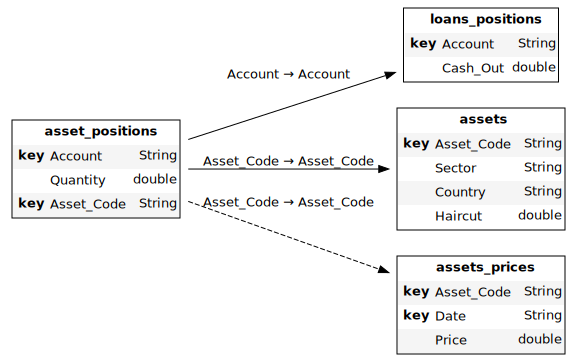

In [14]:
cube.schema

### Quick Analysis with atoti's JupyterLab Extension

In [15]:
# we can perform drill-down to different hierarchies in a pivot table
session.visualize("explore-dataset-using-pivot-table")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### Cube Structure
During cube creation, numeric values are automatically created as measures. Non numeric values are automatically translated to levels under hierarchies of the same name. This can be [configured](https://www.atoti.io/documentation/lib/atoti.html#atoti.session.Session.create_cube) differently.

In [16]:
m = cube.measures
h = cube.hierarchies
lvl = cube.levels

Before we proceed with the data aggregation aspects, let's inspect the hierarchies created

In [17]:
h

Hierarchies(_create_hierarchy_from_arguments=<bound method Cube._create_hierarchy_from_arguments of Cube(_name='Collateral_Management', _hierarchies=..., _measures=Measures())>, _cube_name='Collateral_Management')

We are going to set the hierarchy *Date* as a slicing hierarchy. A slicing hierarchy will not aggregate the data on all its members.  
This means that we always view a subset of the cube by one date by default, which is usually what is needed.

In [18]:
h["Date"].slicing = True

In [19]:
m

Measures()

#### New Measure Creation
From the data we have, we can derive the following:   
$Market Value = Price \times Quantity$  
$Collateral Value = Market Value \times (1 - Haircut)$   
  
The above measures are aggregated over the Account and Asset Code levels in order to compute the Collateral Shortfall at account level:  
$Collateral Shortfall = Collateral Value - Cash Out$   
Where Cash Out is also aggregated at account level           

In [20]:
m["Price"] = tt.value(assets_prices_table["Price"])

In [21]:
m["Market Value"] = tt.agg.sum(
    m["Price"] * m["Quantity.SUM"],
    scope=tt.scope.origin(lvl["Sector"], lvl["Country"], lvl["Account"]),
)

In [22]:
m["Haircut"] = tt.agg.sum(assets_table["Haircut"])

m["Collateral Value"] = tt.agg.sum(
    m["Price"] * m["Quantity.SUM"] * (1 - m["Haircut"]),
    scope=tt.scope.origin(lvl["Sector"], lvl["Country"]),
)

In [23]:
cash_out = tt.value(loans_positions_table["Cash_Out"])
m["Cash Out"] = tt.agg.sum(cash_out, scope=tt.scope.origin(lvl["Account"]))

In [24]:
m["Collateral Shortfall"] = m["Collateral Value"] - m["Cash Out"]

In [25]:
m

Measures()

Let's explore this new measures.

In [26]:
# we can look at the price.VALUE across Date, further split the charts by Asset_Code
session.visualize("times-series")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [27]:
# give a meaningful title to the visualization. This helps to reconcile the objective of the visual and also could be the title of
# the widget when visual is published
session.visualize("haircut-value")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### Monitoring Collateral Shortfall  
We created a pivot table for with the Collateral Shortfall, Market Value, Cash Out and Collateral Value for Accounts.  
Negative Collateral Shortfall are highlighted in red. Feel free to click on the `>` to drill-down to other hierarchies such as Sector to account for the shortfall. 

In [28]:
session.visualize("Collateral Shortfall")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In view of all accounts, using a Gauge chart will show us that we are not yet in shortfall and how far we are from it.   
The red marker shows the total Market value, which is the maximum threshold before shortfall will occur.

In [29]:
session.visualize("total-cash-out")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### Total Cash out Bank wide  
  
We can use a Tree map to visualize the asset concentration. A well diversified portfolio will help to reduce the collateral risks.

In [30]:
session.visualize("Asset Concentration")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

## atoti Dashboard Creation
Until now, we have created a few visualizations. We can right-click on the visuals to publish them as widgets.
These widgets can then be used to build a dashboard.  

<img src="http://data.atoti.io/notebooks/collateral-shortfall-forecast/dashboard.gif" alt="collateral_dashboard" style="zoom:40%;" />

In [31]:
session.link(path="#/dashboard/3a7")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

Click on the URL above to view the dashboard that was prepared. We can use the quick filter to select an account for viewing.  
We can also do a right-click drillthrough to investigate the underlying data.  
  
To play with the UI and explore the data, [you can have a look at our UI documentation here](https://www.activeviam.com/activeui/documentation/index.html).

## Simulations
Now that we have basic monitoring on Collateral Shortfall, we can do some simulations in the data cube.

### Setup Price Simulation

The two kinds of simulation in atoti are:

- Measure simulation
- Source simulation

In Measure simulations, we modify the value of the measures in scenarios of the simulations without duplicating data.  
Source simulation on the other hand, is a simulation created by loading a new source of modified data to the cube.

Here, we will use the Source simulation to simulate variations of the price by considering the price forecast at the following different time horizons:

- 1 day
- 3 days
- 1 week

For each forecasting time horizon, we will predict the Collateral Shortfall.

First, let's load the price forecast tables in a unique table.

In [32]:
# Here, we provide all the files names
files = [
    "s3://data.atoti.io/notebooks/collateral-shortfall-forecast/results/predictions/O-PLS-predictions-1-day-horizon--AC.PA-test.csv",
    "s3://data.atoti.io/notebooks/collateral-shortfall-forecast/results/predictions/O-PLS-predictions-1-day-horizon--BNP.PA-test.csv",
    "s3://data.atoti.io/notebooks/collateral-shortfall-forecast/results/predictions/O-PLS-predictions-1-day-horizon--CAP.PA-test.csv",
    "s3://data.atoti.io/notebooks/collateral-shortfall-forecast/results/predictions/O-PLS-predictions-1-day-horizon--ENGI.PA-test.csv",
    "s3://data.atoti.io/notebooks/collateral-shortfall-forecast/results/predictions/O-PLS-predictions-1-day-horizon--G.MI-test.csv",
    "s3://data.atoti.io/notebooks/collateral-shortfall-forecast/results/predictions/O-PLS-predictions-1-day-horizon--RACE.MI-test.csv",
    "s3://data.atoti.io/notebooks/collateral-shortfall-forecast/results/predictions/O-PLS-predictions-1-day-horizon--SAN.PA-test.csv",
    "s3://data.atoti.io/notebooks/collateral-shortfall-forecast/results/predictions/O-PLS-predictions-1-day-horizon--TIT.MI-test.csv",
    "s3://data.atoti.io/notebooks/collateral-shortfall-forecast/results/predictions/O-PLS-predictions-3-days-horizon--AC.PA-test.csv",
    "s3://data.atoti.io/notebooks/collateral-shortfall-forecast/results/predictions/O-PLS-predictions-3-days-horizon--BNP.PA-test.csv",
    "s3://data.atoti.io/notebooks/collateral-shortfall-forecast/results/predictions/O-PLS-predictions-3-days-horizon--CAP.PA-test.csv",
    "s3://data.atoti.io/notebooks/collateral-shortfall-forecast/results/predictions/O-PLS-predictions-3-days-horizon--ENGI.PA-test.csv",
    "s3://data.atoti.io/notebooks/collateral-shortfall-forecast/results/predictions/O-PLS-predictions-3-days-horizon--G.MI-test.csv",
    "s3://data.atoti.io/notebooks/collateral-shortfall-forecast/results/predictions/O-PLS-predictions-3-days-horizon--RACE.MI-test.csv",
    "s3://data.atoti.io/notebooks/collateral-shortfall-forecast/results/predictions/O-PLS-predictions-3-days-horizon--SAN.PA-test.csv",
    "s3://data.atoti.io/notebooks/collateral-shortfall-forecast/results/predictions/O-PLS-predictions-3-days-horizon--TIT.MI-test.csv",
    "s3://data.atoti.io/notebooks/collateral-shortfall-forecast/results/predictions/O-PLS-predictions-7-days-horizon--AC.PA-test.csv",
    "s3://data.atoti.io/notebooks/collateral-shortfall-forecast/results/predictions/O-PLS-predictions-7-days-horizon--BNP.PA-test.csv",
    "s3://data.atoti.io/notebooks/collateral-shortfall-forecast/results/predictions/O-PLS-predictions-7-days-horizon--CAP.PA-test.csv",
    "s3://data.atoti.io/notebooks/collateral-shortfall-forecast/results/predictions/O-PLS-predictions-7-days-horizon--ENGI.PA-test.csv",
    "s3://data.atoti.io/notebooks/collateral-shortfall-forecast/results/predictions/O-PLS-predictions-7-days-horizon--G.MI-test.csv",
    "s3://data.atoti.io/notebooks/collateral-shortfall-forecast/results/predictions/O-PLS-predictions-7-days-horizon--RACE.MI-test.csv",
    "s3://data.atoti.io/notebooks/collateral-shortfall-forecast/results/predictions/O-PLS-predictions-7-days-horizon--SAN.PA-test.csv",
    "s3://data.atoti.io/notebooks/collateral-shortfall-forecast/results/predictions/O-PLS-predictions-7-days-horizon--TIT.MI-test.csv",
]

price_predictions_df = pd.DataFrame()

for f in files:
    price_predictions_df = pd.concat(
        [price_predictions_df, pd.read_csv(f, index_col=0)]
    )
price_predictions_df = price_predictions_df.sort_index()

In [33]:
price_predictions_df = price_predictions_df.reset_index().rename(
    columns={
        "index": "Date",
        "y": "Price",
        "ŷ": "Price Prediction",
        "Asset Code": "Asset_Code",
        "Model Name": "Best Model",
    }
)

In [34]:
price_predictions_df

,Date,Price,Price Prediction,Best Model,forecasting horizon in days,Asset_Code
0,2021-04-09,32.890001,35.780866,O-PLS,1,AC.PA
1,2021-04-09,12.368000,13.217384,O-PLS,1,ENGI.PA
2,2021-04-09,17.000000,16.805688,O-PLS,1,G.MI
3,2021-04-09,174.700002,147.807664,O-PLS,1,RACE.MI
4,2021-04-09,84.936666,83.538011,O-PLS,1,SAN.PA
...,...,...,...,...,...,...
7059,2022-01-30,13.554000,13.560613,O-PLS,1,ENGI.PA
7060,2022-01-30,92.750000,93.115610,O-PLS,1,SAN.PA
7061,2022-01-30,32.360001,32.106985,O-PLS,1,AC.PA
7062,2022-01-30,202.899994,203.011233,O-PLS,1,RACE.MI


In [35]:
price_predictions_df_1_day = price_predictions_df[
    price_predictions_df["forecasting horizon in days"] == 1
][["Date", "Asset_Code", "Price Prediction"]].copy()
price_predictions_df_1_day = pd.melt(
    price_predictions_df_1_day.sort_values(["Asset_Code", "Date"]),
    id_vars=["Date", "Asset_Code"],
    value_vars=["Price Prediction"],
    value_name="Price",
)
price_predictions_df_1_day = price_predictions_df_1_day[
    ["Asset_Code", "Date", "Price"]
].set_index(["Asset_Code", "Date"])
price_predictions_df_1_day

Price
Asset_Code Date                 
AC.PA      2021-04-09  35.780866
           2021-04-10  35.433169
           2021-04-11  35.181541
           2021-04-12  35.181017
           2021-04-13  33.437613
...                          ...
TIT.MI     2022-01-26   0.413914
           2022-01-27   0.416311
           2022-01-28   0.410695
           2022-01-29   0.410624
           2022-01-30   0.412594

[2376 rows x 1 columns]

In [36]:
price_predictions_df_3_days = price_predictions_df[
    price_predictions_df["forecasting horizon in days"] == 3
][["Date", "Asset_Code", "Price Prediction"]].copy()
price_predictions_df_3_days = pd.melt(
    price_predictions_df_3_days.sort_values(["Asset_Code", "Date"]),
    id_vars=["Date", "Asset_Code"],
    value_vars=["Price Prediction"],
    value_name="Price",
)
price_predictions_df_3_days = price_predictions_df_3_days[
    ["Asset_Code", "Date", "Price"]
].set_index(["Asset_Code", "Date"])
price_predictions_df_3_days

Price
Asset_Code Date                 
AC.PA      2021-04-09  36.072508
           2021-04-10  37.855512
           2021-04-11  37.062514
           2021-04-12  37.440131
           2021-04-13  33.403387
...                          ...
TIT.MI     2022-01-24   0.407521
           2022-01-25   0.404238
           2022-01-26   0.415667
           2022-01-27   0.420697
           2022-01-28   0.415464

[2360 rows x 1 columns]

In [37]:
price_predictions_df_1_week = price_predictions_df[
    price_predictions_df["forecasting horizon in days"] == 7
][["Date", "Asset_Code", "Price Prediction"]].copy()
price_predictions_df_1_week = pd.melt(
    price_predictions_df_1_week.sort_values(["Asset_Code", "Date"]),
    id_vars=["Date", "Asset_Code"],
    value_vars=["Price Prediction"],
    value_name="Price",
)
price_predictions_df_1_week = price_predictions_df_1_week[
    ["Asset_Code", "Date", "Price"]
].set_index(["Asset_Code", "Date"])
price_predictions_df_1_week

Price
Asset_Code Date                 
AC.PA      2021-04-09  38.566016
           2021-04-10  37.782206
           2021-04-11  40.077299
           2021-04-12  34.906907
           2021-04-13  36.713910
...                          ...
TIT.MI     2022-01-20   0.413905
           2022-01-21   0.396130
           2022-01-22   0.405979
           2022-01-23   0.413747
           2022-01-24   0.412522

[2328 rows x 1 columns]

In [38]:
assets_prices_table.head(10000)

Price
Asset_Code Date                 
AC.PA      2021-04-09  33.040001
           2021-04-10  32.890001
           2021-04-11  32.740000
           2021-04-12  32.590000
           2021-04-13  32.840000
...                          ...
TIT.MI     2022-01-26   0.409600
           2022-01-27   0.408100
           2022-01-28   0.406900
           2022-01-29   0.410000
           2022-01-30   0.413100

[2376 rows x 1 columns]

Notice that the dataframes with the predictions do not have exactly the same size. This is because we consider different time horizons for the predictions.
**To be able to compare the different scenarios, we will filter them on the Date column and consider the period comprised from 2021/04/08 and 2022/01/24.**

To achieve that, we consider only the date in the following index for all the scenarios:

In [39]:
index = price_predictions_df_1_week.index
index

MultiIndex([( 'AC.PA', '2021-04-09'),
            ( 'AC.PA', '2021-04-10'),
            ( 'AC.PA', '2021-04-11'),
            ( 'AC.PA', '2021-04-12'),
            ( 'AC.PA', '2021-04-13'),
            ( 'AC.PA', '2021-04-14'),
            ( 'AC.PA', '2021-04-15'),
            ( 'AC.PA', '2021-04-16'),
            ( 'AC.PA', '2021-04-17'),
            ( 'AC.PA', '2021-04-18'),
            ...
            ('TIT.MI', '2022-01-15'),
            ('TIT.MI', '2022-01-16'),
            ('TIT.MI', '2022-01-17'),
            ('TIT.MI', '2022-01-18'),
            ('TIT.MI', '2022-01-19'),
            ('TIT.MI', '2022-01-20'),
            ('TIT.MI', '2022-01-21'),
            ('TIT.MI', '2022-01-22'),
            ('TIT.MI', '2022-01-23'),
            ('TIT.MI', '2022-01-24')],
           names=['Asset_Code', 'Date'], length=2328)

Now, let's modify the assets_prices_df that was previously loaded into the cube by modifying the price column by the values corresponding to the price forecast.
For our *Price simulation*, we shall load this modified dataframe directly into the table as a scenario.

#### Base scenario: Ground Truth Price

In [40]:
assets_prices_df_base = assets_prices_df.loc[index]
assets_prices_df = assets_prices_df_base.copy()
assets_prices_df

Price
Asset_Code Date                 
AC.PA      2021-04-09  33.040001
           2021-04-10  32.890001
           2021-04-11  32.740000
           2021-04-12  32.590000
           2021-04-13  32.840000
...                          ...
TIT.MI     2022-01-20   0.424100
           2022-01-21   0.419300
           2022-01-22   0.415833
           2022-01-23   0.412367
           2022-01-24   0.408900

[2328 rows x 1 columns]

In [41]:
# In Source Simulation, we do not perform simulation_setup. We just load it to the table as scenarios.
with session.start_transaction(scenario_name="Actual"):
    # assets_prices_table.scenarios["Actual Collateral Shortfall"].drop()  # Clear the data from the "base" scenario before loading our new data
    assets_prices_table.scenarios["Actual"].load_pandas(assets_prices_df)

#### Scenario 1: Forecast At 1 Day

In [42]:
assets_prices_df = price_predictions_df_1_day.loc[index].copy()
assets_prices_df

Price
Asset_Code Date                 
AC.PA      2021-04-09  35.780866
           2021-04-10  35.433169
           2021-04-11  35.181541
           2021-04-12  35.181017
           2021-04-13  33.437613
...                          ...
TIT.MI     2022-01-20   0.409226
           2022-01-21   0.408959
           2022-01-22   0.410334
           2022-01-23   0.407763
           2022-01-24   0.404602

[2328 rows x 1 columns]

In [43]:
with session.start_transaction(scenario_name="Forecast At 1 Day"):
    # assets_prices_table.scenarios["Forecast At 1 Day"].drop()  # Clear the data from the "base" scenario before loading our new data
    assets_prices_table.scenarios["Forecast At 1 Day"].load_pandas(assets_prices_df)

#### Scenario 2: Forecast At 3 Days

In [44]:
assets_prices_df = price_predictions_df_3_days.loc[index].copy()
assets_prices_df

Price
Asset_Code Date                 
AC.PA      2021-04-09  36.072508
           2021-04-10  37.855512
           2021-04-11  37.062514
           2021-04-12  37.440131
           2021-04-13  33.403387
...                          ...
TIT.MI     2022-01-20   0.407260
           2022-01-21   0.401424
           2022-01-22   0.408981
           2022-01-23   0.406330
           2022-01-24   0.407521

[2328 rows x 1 columns]

In [45]:
# In Source Simulation, we do not perform simulation_setup. We just load it to the table as scenarios.
with session.start_transaction(scenario_name="Forecast At 3 Days"):
    # assets_prices_table.scenarios["Forecast At 3 Days"].drop()  # Clear the data from the "base" scenario before loading our new data
    assets_prices_table.scenarios["Forecast At 3 Days"].load_pandas(assets_prices_df)

#### Scenario 3: Forecast At 1 Week

In [46]:
assets_prices_df = price_predictions_df_1_week.loc[index].copy()
assets_prices_df

Price
Asset_Code Date                 
AC.PA      2021-04-09  38.566016
           2021-04-10  37.782206
           2021-04-11  40.077299
           2021-04-12  34.906907
           2021-04-13  36.713910
...                          ...
TIT.MI     2022-01-20   0.413905
           2022-01-21   0.396130
           2022-01-22   0.405979
           2022-01-23   0.413747
           2022-01-24   0.412522

[2328 rows x 1 columns]

In [47]:
with session.start_transaction(scenario_name="Forecast At 1 Week"):
    # assets_prices_table.scenarios["Forecast At 1 Week"].drop()  # Clear the data from the "base" scenario before loading our new data
    assets_prices_table.scenarios["Forecast At 1 Week"].load_pandas(assets_prices_df)

### Comparing the different scenarios
Now, let's compare the impact on the collateral shortfall when considering different time horizon for the forecast.

In [48]:
session.visualize("Collateral Shortfall Forecasts comparison - Table")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [49]:
session.visualize("Collateral Shortfall Forecasts comparison - Plot")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

We observe that the projections are close to the actual calculation of the Collateral Shortfall value for Daniel EK and Musk. Also, they are not far from the actual value for Buffet, Gates, and Niel.

However, in the case of Bezos & MacKenzie, we observe that the projections are less accurate.

Additionally, in general, we note that for most of the accounts, the forecast at 1 and 3 days are close whereas the one at 1-week horizon tends to differ significantly. 

These observations are probably due to the fact that these portofolios do not comprised exactly the same assets, for which we have use the same model and assumptions for the forecast. This could lead to great accuracy for some assets, and less for others. As a consequence, depending on which assets are comprised in the account, the projections could be more or less accurate in comparison to the the actual Collateral Shortfall. 

We will explain further the performing level of the forecast later in this notebook.

Check out the dashboard that was prepared in advance.

In [50]:
session.link(path="#/dashboard/69e")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

### Quality of the Predictions

In [51]:
for asset in set(index.get_level_values(0)):
    # Ground truth
    y = assets_prices_df_base.loc[index].loc[asset]["Price"]

    # Prediction at 1 day
    y_pred_1d = price_predictions_df_1_day.loc[index].loc[asset]["Price"]
    r2_1d = r2_score(y, y_pred_1d)
    rmse_1d = mean_squared_error(y, y_pred_1d)
    mape_1d = utils.mean_absolute_percentage_error(y, y_pred_1d)

    # Prediction at 3 days
    y_pred_3d = price_predictions_df_3_days.loc[index].loc[asset]["Price"]
    r2_3d = r2_score(y, y_pred_3d)
    rmse_3d = mean_squared_error(y, y_pred_3d)
    mape_3d = utils.mean_absolute_percentage_error(y, y_pred_3d)

    # Prediction at 1 week
    y_pred_1w = price_predictions_df_1_week.loc[index].loc[asset]["Price"]
    r2_1w = r2_score(y, y_pred_1w)
    rmse_1w = mean_squared_error(y, y_pred_1w)
    mape_1w = utils.mean_absolute_percentage_error(y, y_pred_1w)

    # Results summary table
    results_df = pd.DataFrame(
        index=pd.Series(
            ["Prediction At 1 Day", "Prediction At 3 Days", "Prediction At 1 Week"]
        ),
        columns=["y_mean", "y_std", "ŷ_mean", "ŷ_std", "R2", "RMSE", "MAPE"],
    )

    metrics = {
        "Prediction At 1 Day": {
            "y_mean": np.mean(y),
            "y_std": np.std(y),
            "ŷ_mean": np.mean(y_pred_1d),
            "ŷ_std": np.std(y_pred_1d),
            "R2": r2_1d,
            "RMSE": rmse_1d,
            "MAPE": mape_1d,
        },
        "Prediction At 3 Days": {
            "y_mean": np.mean(y),
            "y_std": np.std(y),
            "ŷ_mean": np.mean(y_pred_3d),
            "ŷ_std": np.std(y_pred_3d),
            "R2": r2_3d,
            "RMSE": rmse_3d,
            "MAPE": mape_3d,
        },
        "Prediction At 1 Week": {
            "y_mean": np.mean(y),
            "y_std": np.std(y),
            "ŷ_mean": np.mean(y_pred_1w),
            "ŷ_std": np.std(y_pred_1w),
            "R2": r2_1w,
            "RMSE": rmse_1w,
            "MAPE": mape_1w,
        },
    }

    for k, v in metrics.items():
        for m in list(v.keys()):
            results_df.loc[k, m] = utils.truncate(v[m], 3)

    print(f"Result summary for asset code {asset}:\n{results_df.to_markdown()}\n\n")

Result summary for asset code SAN.PA:
|                      |   y_mean |   y_std |   ŷ_mean |   ŷ_std |    R2 |   RMSE |   MAPE |
|:---------------------|---------:|--------:|---------:|--------:|------:|-------:|-------:|
| Prediction At 1 Day  |   86.785 |    2.31 |   86.735 |   2.371 | 0.901 |  0.523 |  0.003 |
| Prediction At 3 Days |   86.785 |    2.31 |   86.642 |   2.107 | 0.906 |  0.501 |  0.006 |
| Prediction At 1 Week |   86.785 |    2.31 |   87.505 |   2.326 | 0.568 |  2.302 |  0.012 |


Result summary for asset code CAP.PA:
|                      |   y_mean |   y_std |   ŷ_mean |   ŷ_std |     R2 |    RMSE |   MAPE |
|:---------------------|---------:|--------:|---------:|--------:|-------:|--------:|-------:|
| Prediction At 1 Day  |   181.96 |  21.608 |  185.526 |  23.451 |  0.95  |  23.146 |  0.019 |
| Prediction At 3 Days |   181.96 |  21.608 |  191.041 |  27.823 |  0.707 | 136.543 |  0.048 |
| Prediction At 1 Week |   181.96 |  21.608 |  200.523 |  35.812 | -0.271 | 5

The result tables show the following predictions, and regression evaluation metrics, for each time horizon prediction:

- **y_mean:** The average of the actual price of the considered asset
- **y_std:** The standard deviation of the actual price of the considered asset
- **ŷ_mean:** The average of the predicted price of the considered asset
- **ŷ_std:** The average standard deviation of the predicted price of the considered asset
- **R2:** The coefficient of determination (R squared) or regression score of the model
- **RMSE:** The Root Mean Squared Error
- **MAPE:** The Mean Absolute Percentage Error

Refer to https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics for the definitions.

<font color='blue' size=3>The results tables show that the forecasting models are good in general:

- <font color='blue' size=3>On average, they predict values close to the actual values with associated standard deviations comparable to the actual values as well. This demonstrates a good fit of the model with a low bias, except for the asset CAP.PA;
    
- <font color='blue' size=3>The R2 values are also good, except for a few assets like CAP.PA, ENGI.PA and TIT.MI, they are above 0.65. This shows good correlations between the actual values and the predictions;
    
- <font color='blue' size=3>The RMSE are low compared to the actual prices except for the assets CAP.PA;
    
- <font color='blue' size=3>The MAPE values are good as they are lower than 0.05 (i.e. less than 5% deviation from the actual prices on avrage). This demonstrates that, on average, the relative error between the prediction and the actual price is less than 5%. 
    
<font color='blue' size=3> Here, we can see the difference of performance of the models corresponding at different time horizon. **As expected with time series forecast, we observe that the closer the closer the time horizon, the better forecast.**
    
<font color='blue' size=3> Furthermore, we can see different performing levels at different time horizons for the same assets. But, we can also see different performing levels at the same time horizon - so the same model -  for different assets. This is due to the fact that the different assets do not have necessarily the haracteristics in terms of trends and seasonality, but for simplicity we have used the same assumptions to create their predictive features and forecast models. Which is not the best solution, and is definitely a way of improvment of our approach.

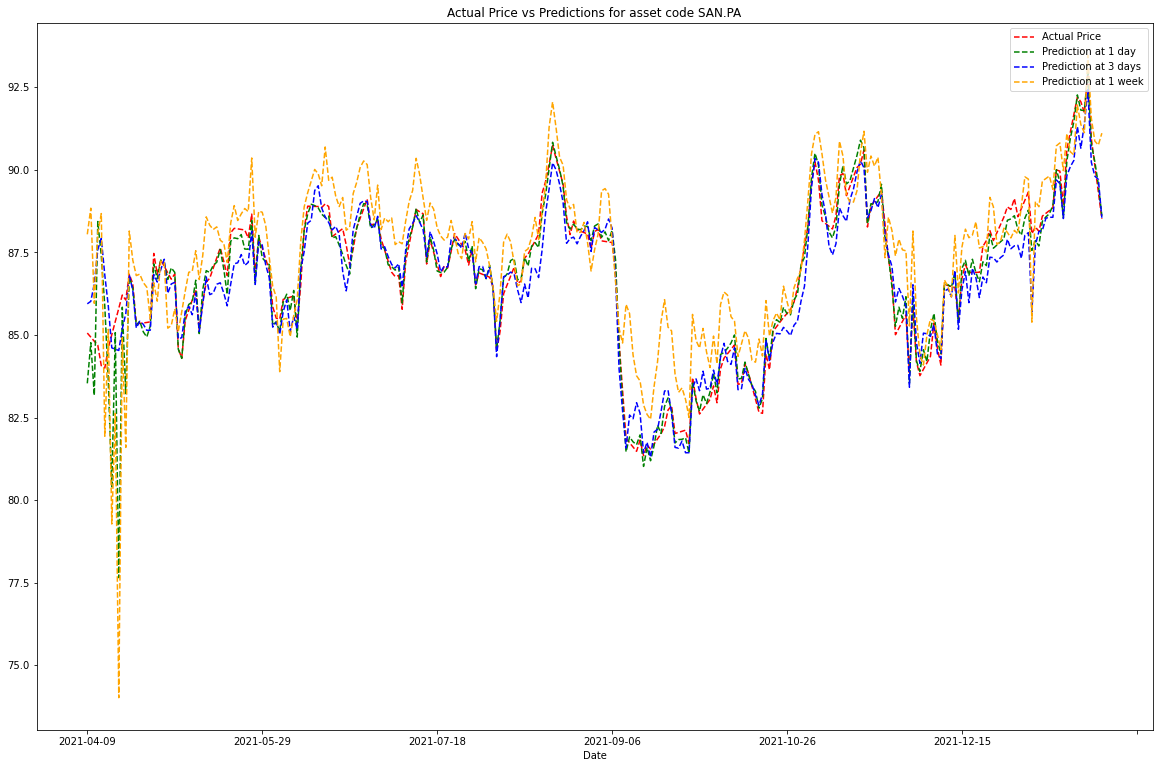

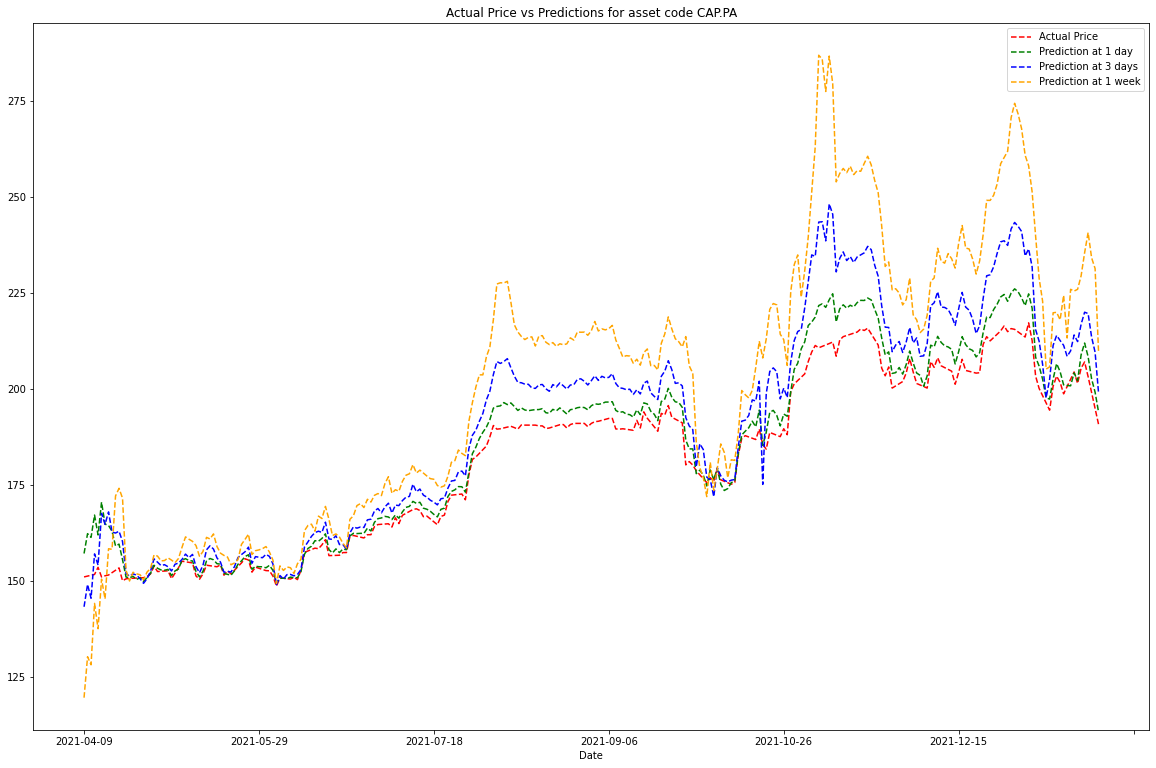

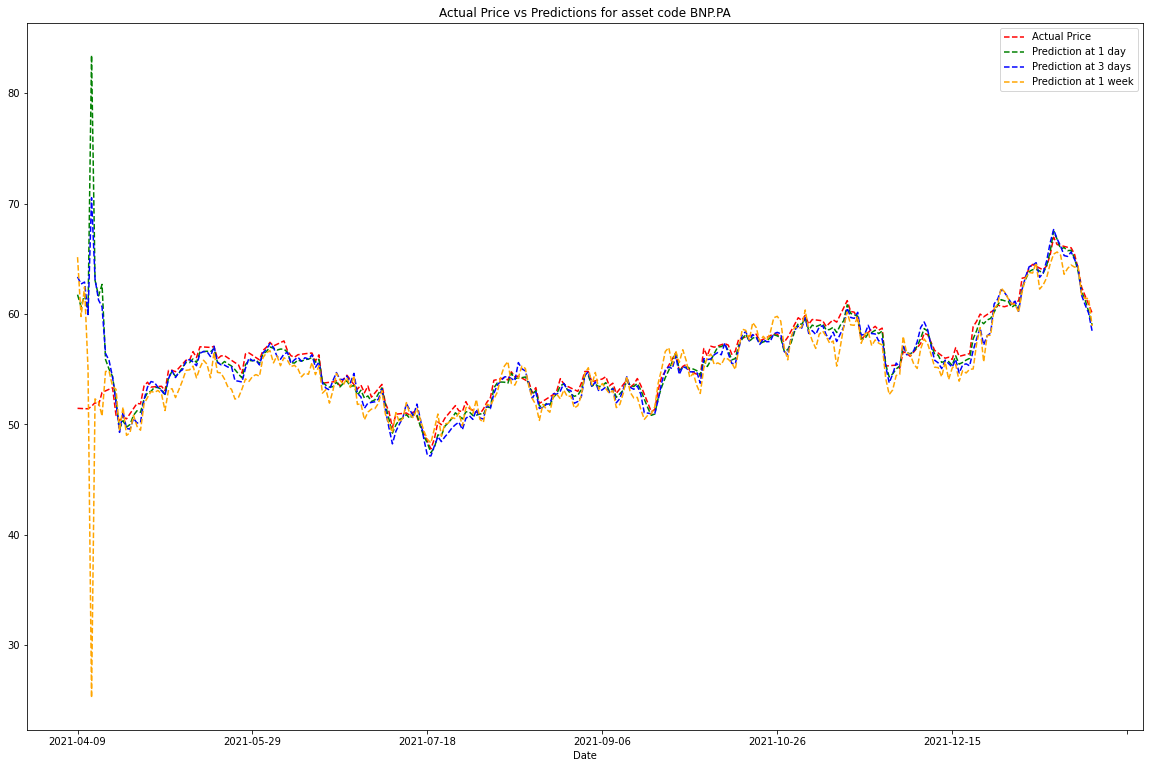

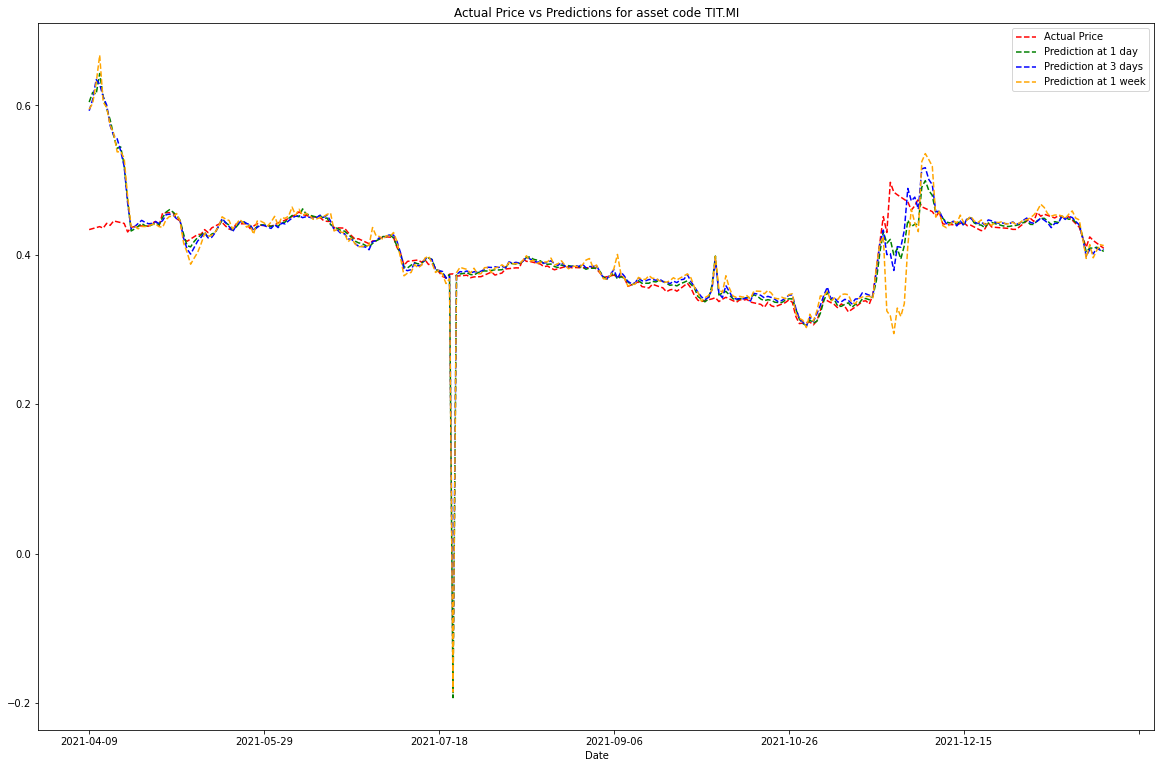

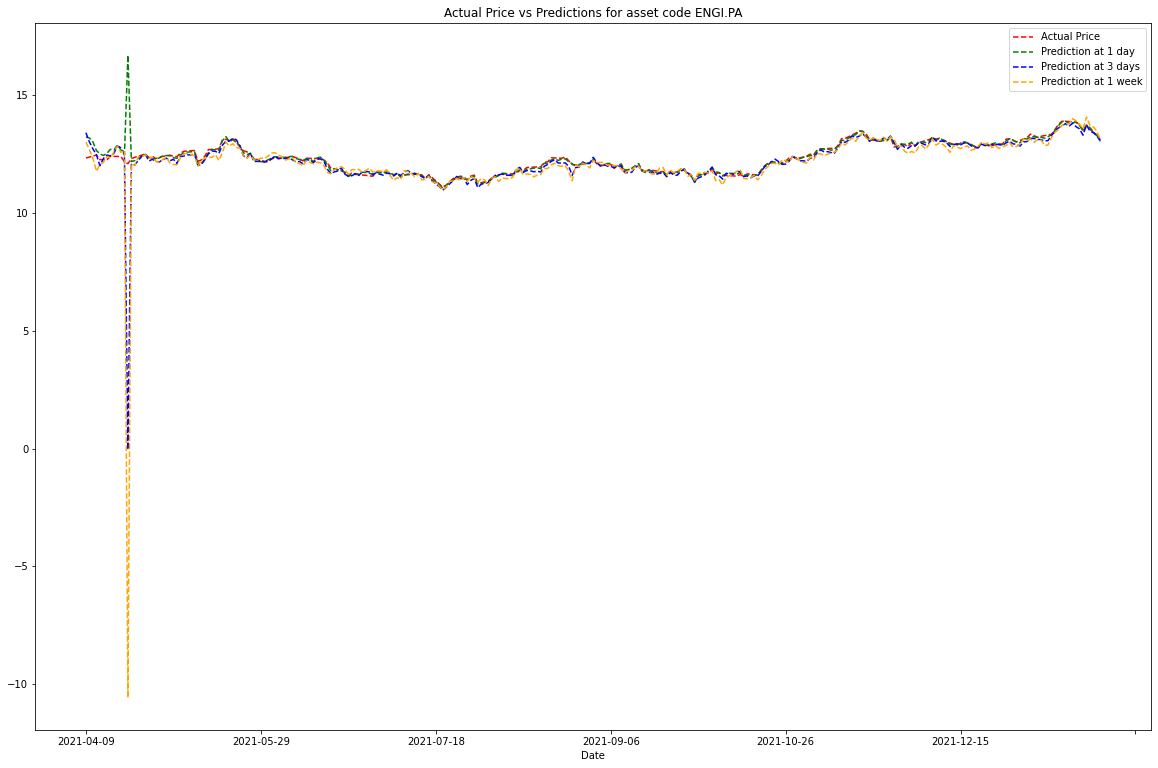

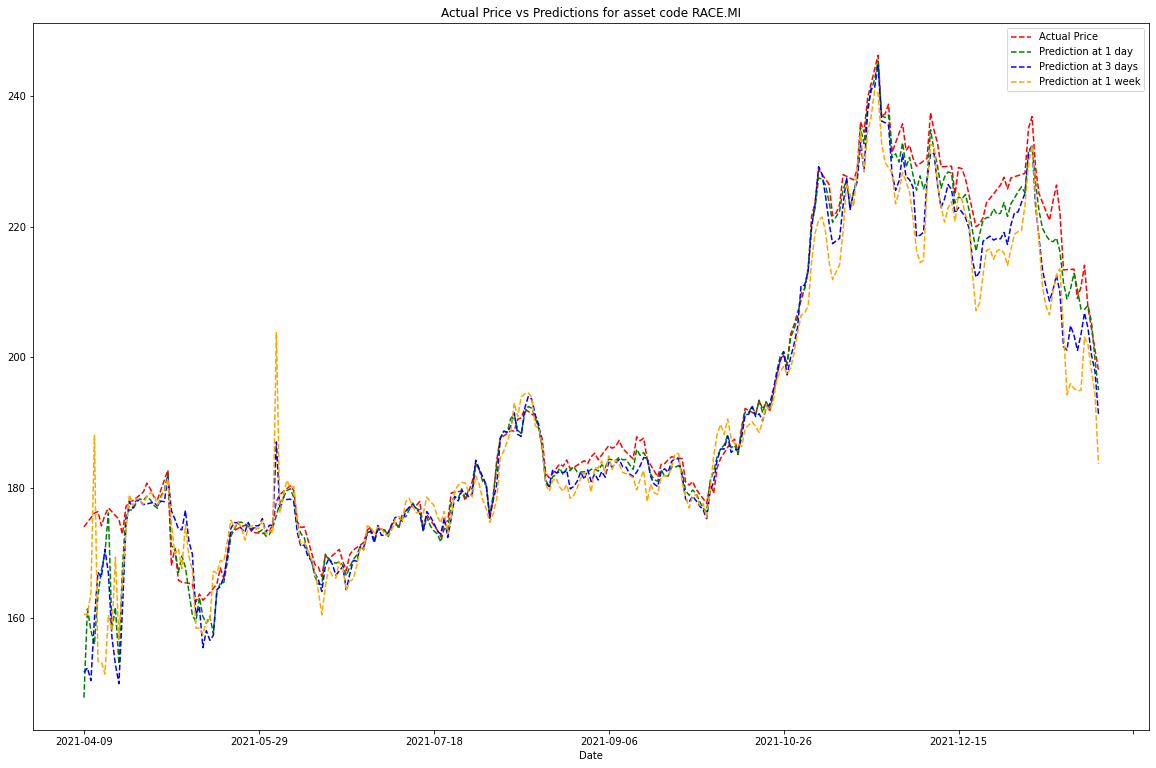

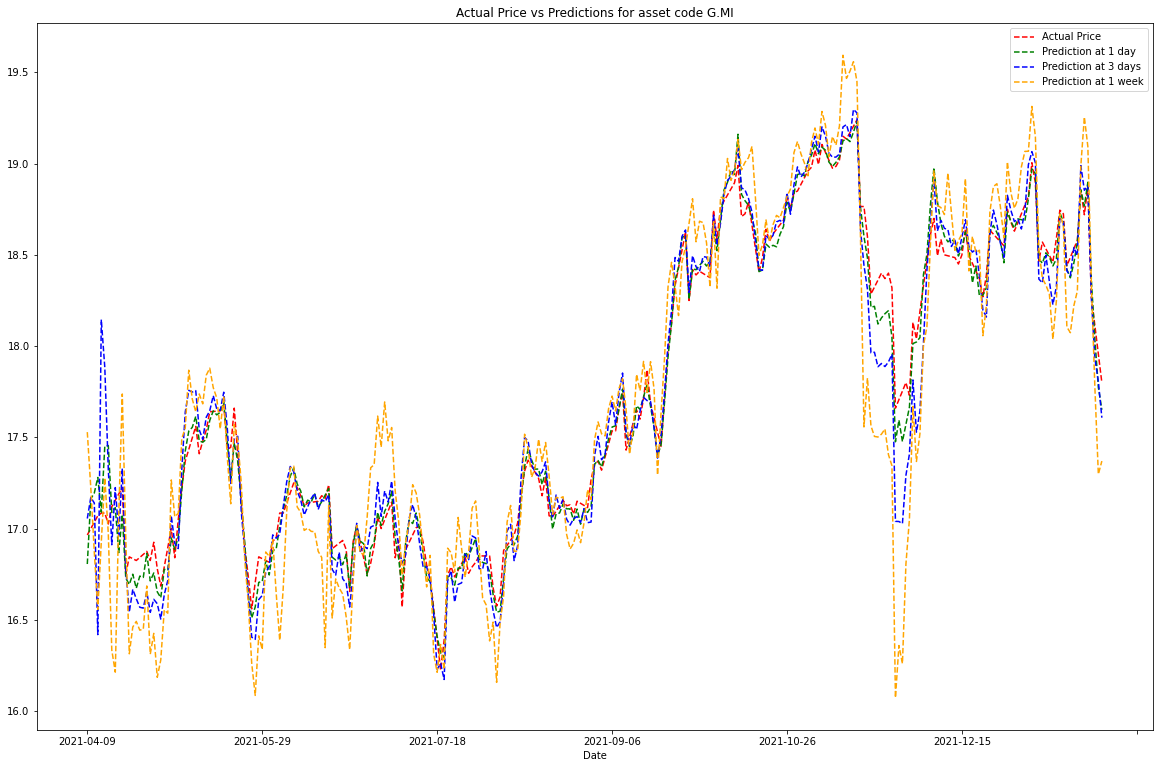

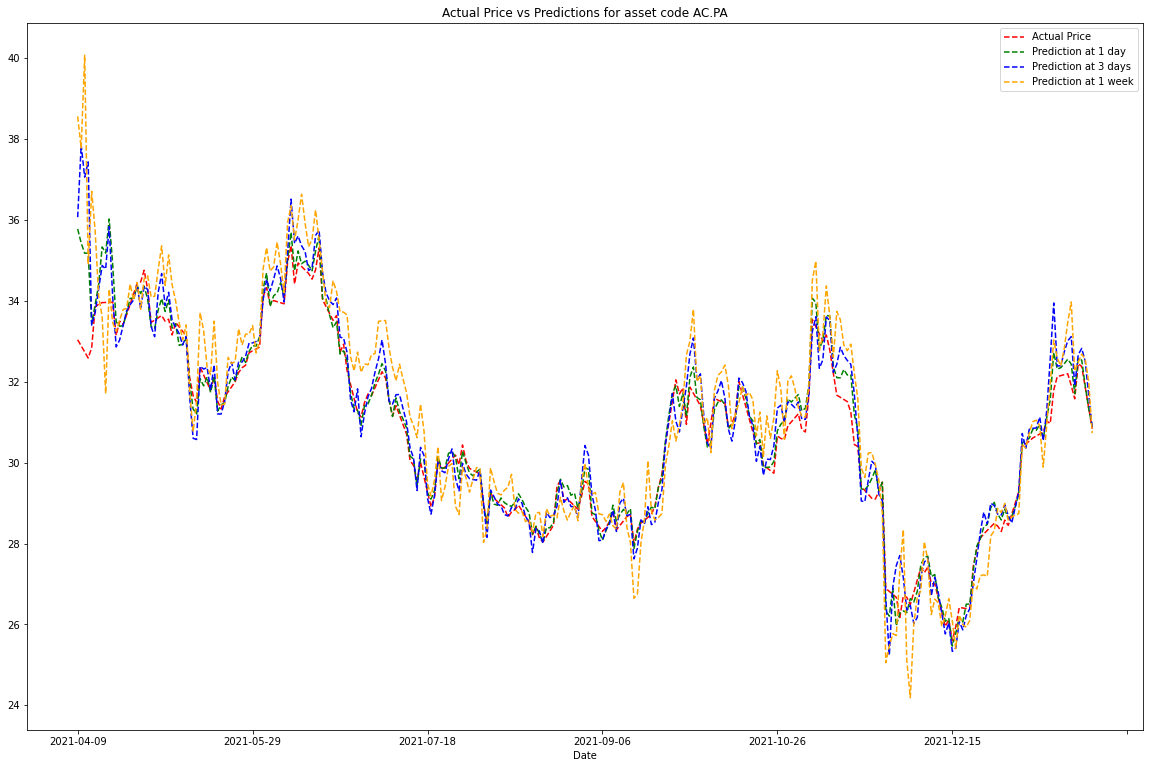

In [52]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (20, 13)

colors = {
    "Actual Price": "r",
    "Prediction at 1 day": "g",
    "Prediction at 3 days": "b",
    "Prediction at 1 week": "orange",
}
styles = {
    "Actual Price": "--",
    "Prediction at 1 day": "--",
    "Prediction at 3 days": "--",
    "Prediction at 1 week": "--",
}

for asset in set(index.get_level_values(0)):
    y = (
        assets_prices_df_base.loc[index]
        .loc[asset]
        .reset_index()
        .rename(columns={"Price": "Actual Price"})
    )
    y_pred_1d = (
        price_predictions_df_1_day.loc[index]
        .loc[asset]
        .reset_index()
        .rename(columns={"Price": "Prediction at 1 day"})
    )
    y_pred_3d = (
        price_predictions_df_3_days.loc[index]
        .loc[asset]
        .reset_index()
        .rename(columns={"Price": "Prediction at 3 days"})
    )
    y_pred_1w = (
        price_predictions_df_1_week.loc[index]
        .loc[asset]
        .reset_index()
        .rename(columns={"Price": "Prediction at 1 week"})
    )

    # df = pd.merge(left=y, right=y_pred_1d, on='Date')
    df = y.merge(
        y_pred_1d.merge(
            y_pred_3d.merge(y_pred_1w, how="inner", on="Date"), how="inner", on="Date"
        ),
        how="inner",
        on="Date",
    )
    df = df.set_index("Date")

    df.plot(
        color=[colors.get(x) for x in df.columns],
        style=[styles.get(x) for x in df.columns],
    )
    plt.title(f"Actual Price vs Predictions for asset code {asset}")
    plt.legend(loc="upper right")
    plt.show()

<font color='blue' size=3>The visualizations confirmed the previous observations, as well as the good fit of the different models in general:

- <font color='blue' size=3>In general, the curves of predicted prices correspond well to those of actual prices, in terms of amplitude and trend;
    
- <font color='blue' size=3>The forecast at 1 day appears to be the best globally;
    
- <font color='blue' size=3>Although the 1-week forecast seems to be not as good as the other models, its curves seem to be quite good since they follow the trend of real prices well in most cases, with however some relatively large deviations in amplitude for the different assets except BNP.PA, RACE.MI, TIT.MI, and ENGI.PA

## Conclusion

<font size=3>In this analysis, we have analyzed the risk of Collateral Shortfall for some portfolios in projection in a near future at different time horizons.

<font size=3>While the different time horizons used show an overall good forecast accuracy, we observe that the models' performance decrease when we increase the forecast horizon: in general, the closer the forecast horizon, the better the forecast values.

<font size=3>We have shown how machine learning can be very effective in helping portfolio managers make informed decisions and manage risk, taking into account different considerations such as the time/accuracy trade-off. In fact, machine learning can help assess the best strategy for the firm between a longer-term view with relatively low accuracy, and a shorter-term view with more accurate projections.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=collateral-monitoring" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover-try.png" alt="Try atoti"></a></div>